In [19]:
import os
import pandas as pd
import string
from datetime import datetime
from os import path
import json
import numpy as np
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import seaborn as sns
import modify_dataset

In [20]:
_HOME_ = path.expanduser("~") + "/PHD"

In [21]:
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [149]:
df_chem_phys = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Create_dataset/df_chem_phys_mod_data.csv")
df_chem_phys["id"] = pd.Categorical(df_chem_phys["id"], categories=ordered_id, ordered=True)
df_chem_phys["Region"] = pd.Categorical(df_chem_phys["Region"], categories=ordered_regions, ordered=True)
df_chem_phys["Date"] = pd.to_datetime(df_chem_phys["Date"])
df_chem_phys["SampleDepth"] = df_chem_phys["SampleDepth"].astype("float")

In [148]:
df_chem_phys = df_chem_phys.loc[~df_chem_phys["QF"].isin(["3", "4"]), :]
#df_chem_phys.loc[:, "SampleDepth"] = df_chem_phys.loc[:, "SampleDepth"].apply(lambda x: round(x))

In [ ]:
def find_season(month, seasons): 
    for name, months in seasons.items(): 
        if month in months: 
            return name, month 

In [155]:
def make_string_season(dates, seasons): 
    season_list = np.empty(len(dates), dtype = "<U11")
    for i, date in enumerate(dates): 
        season, month = find_season(date.month, seasons) 
        season_list[i] = f"{season}-{date.year}"
    return season_list

In [ ]:
def add_season_column(phyto_abund_simplified, seasons): 
    phyto_abund_simplified["Season_year"] = make_string_season(phyto_abund_simplified["Date"], seasons)
    phyto_abund_simplified["Season"] = list(map(lambda x: x.split("-")[0], phyto_abund_simplified["Season_year"]))
    phyto_abund_simplified["Season"] = pd.Categorical(phyto_abund_simplified["Season"], categories=["Winter", "Spring", "Summer", "Autumn"], ordered=True)
    return phyto_abund_simplified

In [165]:
def add_mid_year_column(df): 
    months = df["Date"].dt.month
    df["Mid_year"] = ["Summer" if 4 <= month <= 9 else "Winter" for month in months]
    return df

# Temp

In [167]:
Temp = df_chem_phys.query("Nutrient == 'T' and Concentration > 0")
Temp.loc[:, "SampleDepth"] = Temp.loc[:, "SampleDepth"].apply(lambda x: round(x * 2) / 2)
Temp = Temp.groupby(["Region", "Date", "id", "SampleDepth"], observed=True).mean(numeric_only=True).reset_index()
Temp = modify_dataset.add_season_column(Temp, seasons)
Temp = add_mid_year_column(Temp)

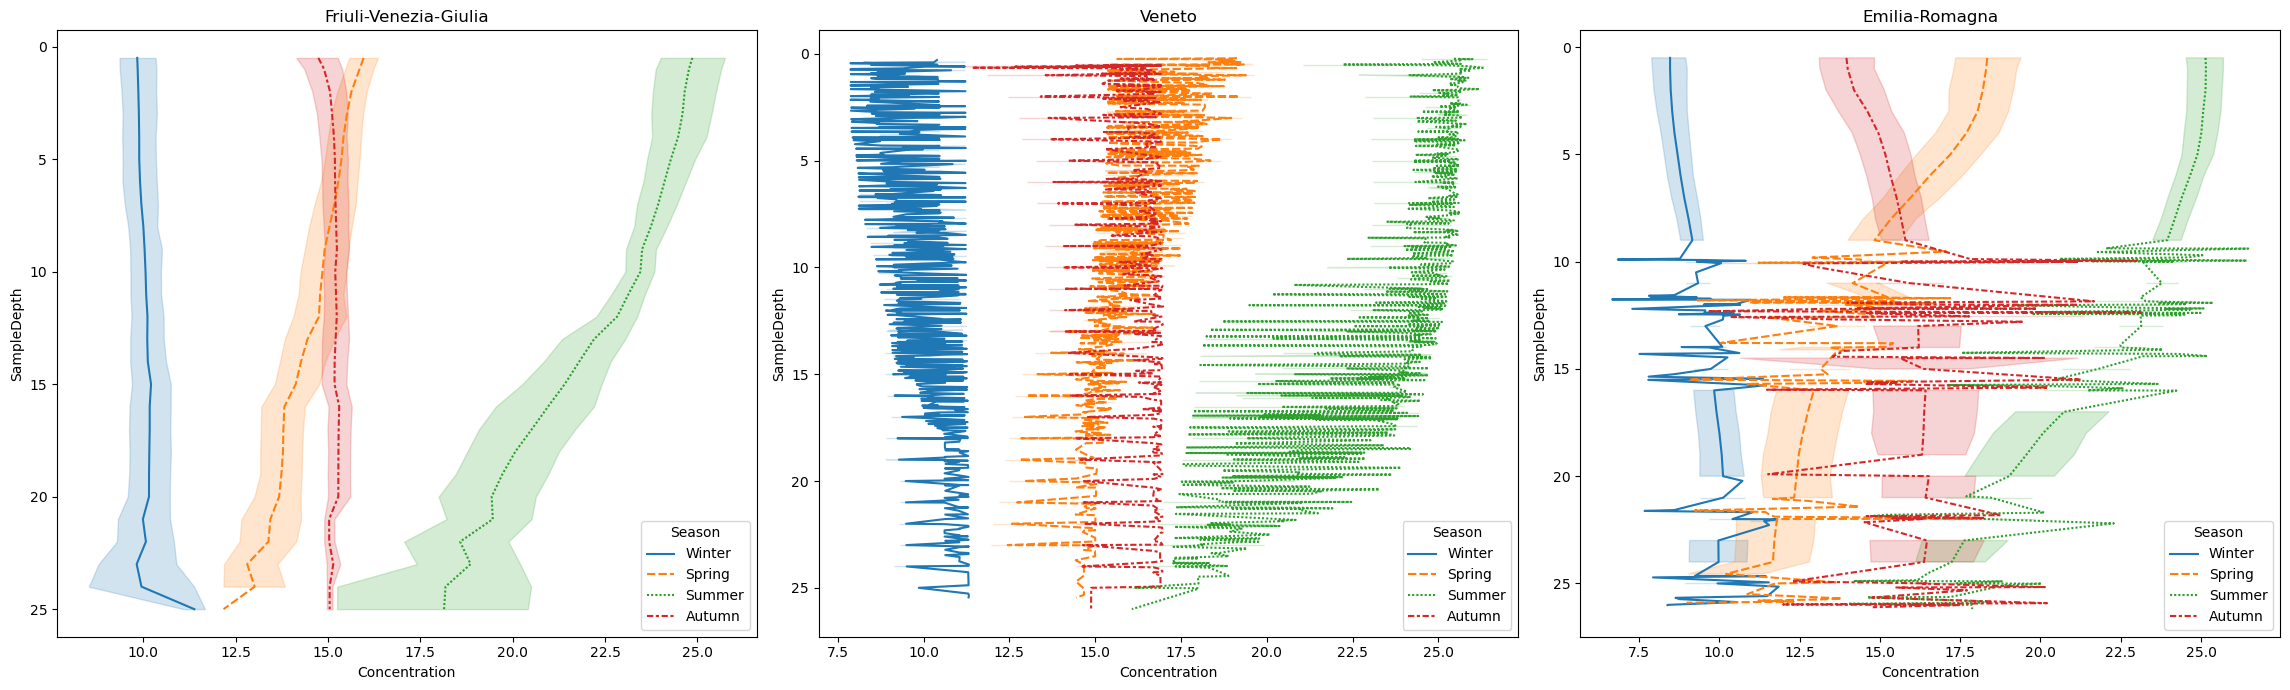

In [58]:
colors = sns.color_palette("tab10", n_colors=4)
color_dict = dict(zip(seasons, colors))

fig, axs = plt.subplots(1, 3, figsize=(23, 7))
axs = axs.ravel()
for ax, (Region, df_region) in zip(axs, Temp.groupby("Region", observed=True)): 
    sns.lineplot(
        data=df_region.query("SampleDepth <= 27"),
        x = "Concentration", 
        y = "SampleDepth", 
        orient = "y", 
        hue = "Season",
        style = "Season",
        #errorbar=None,
        palette=color_dict,
        ax = ax
    )
    ax.invert_yaxis()
    ax.set_title(Region)
plt.tight_layout()

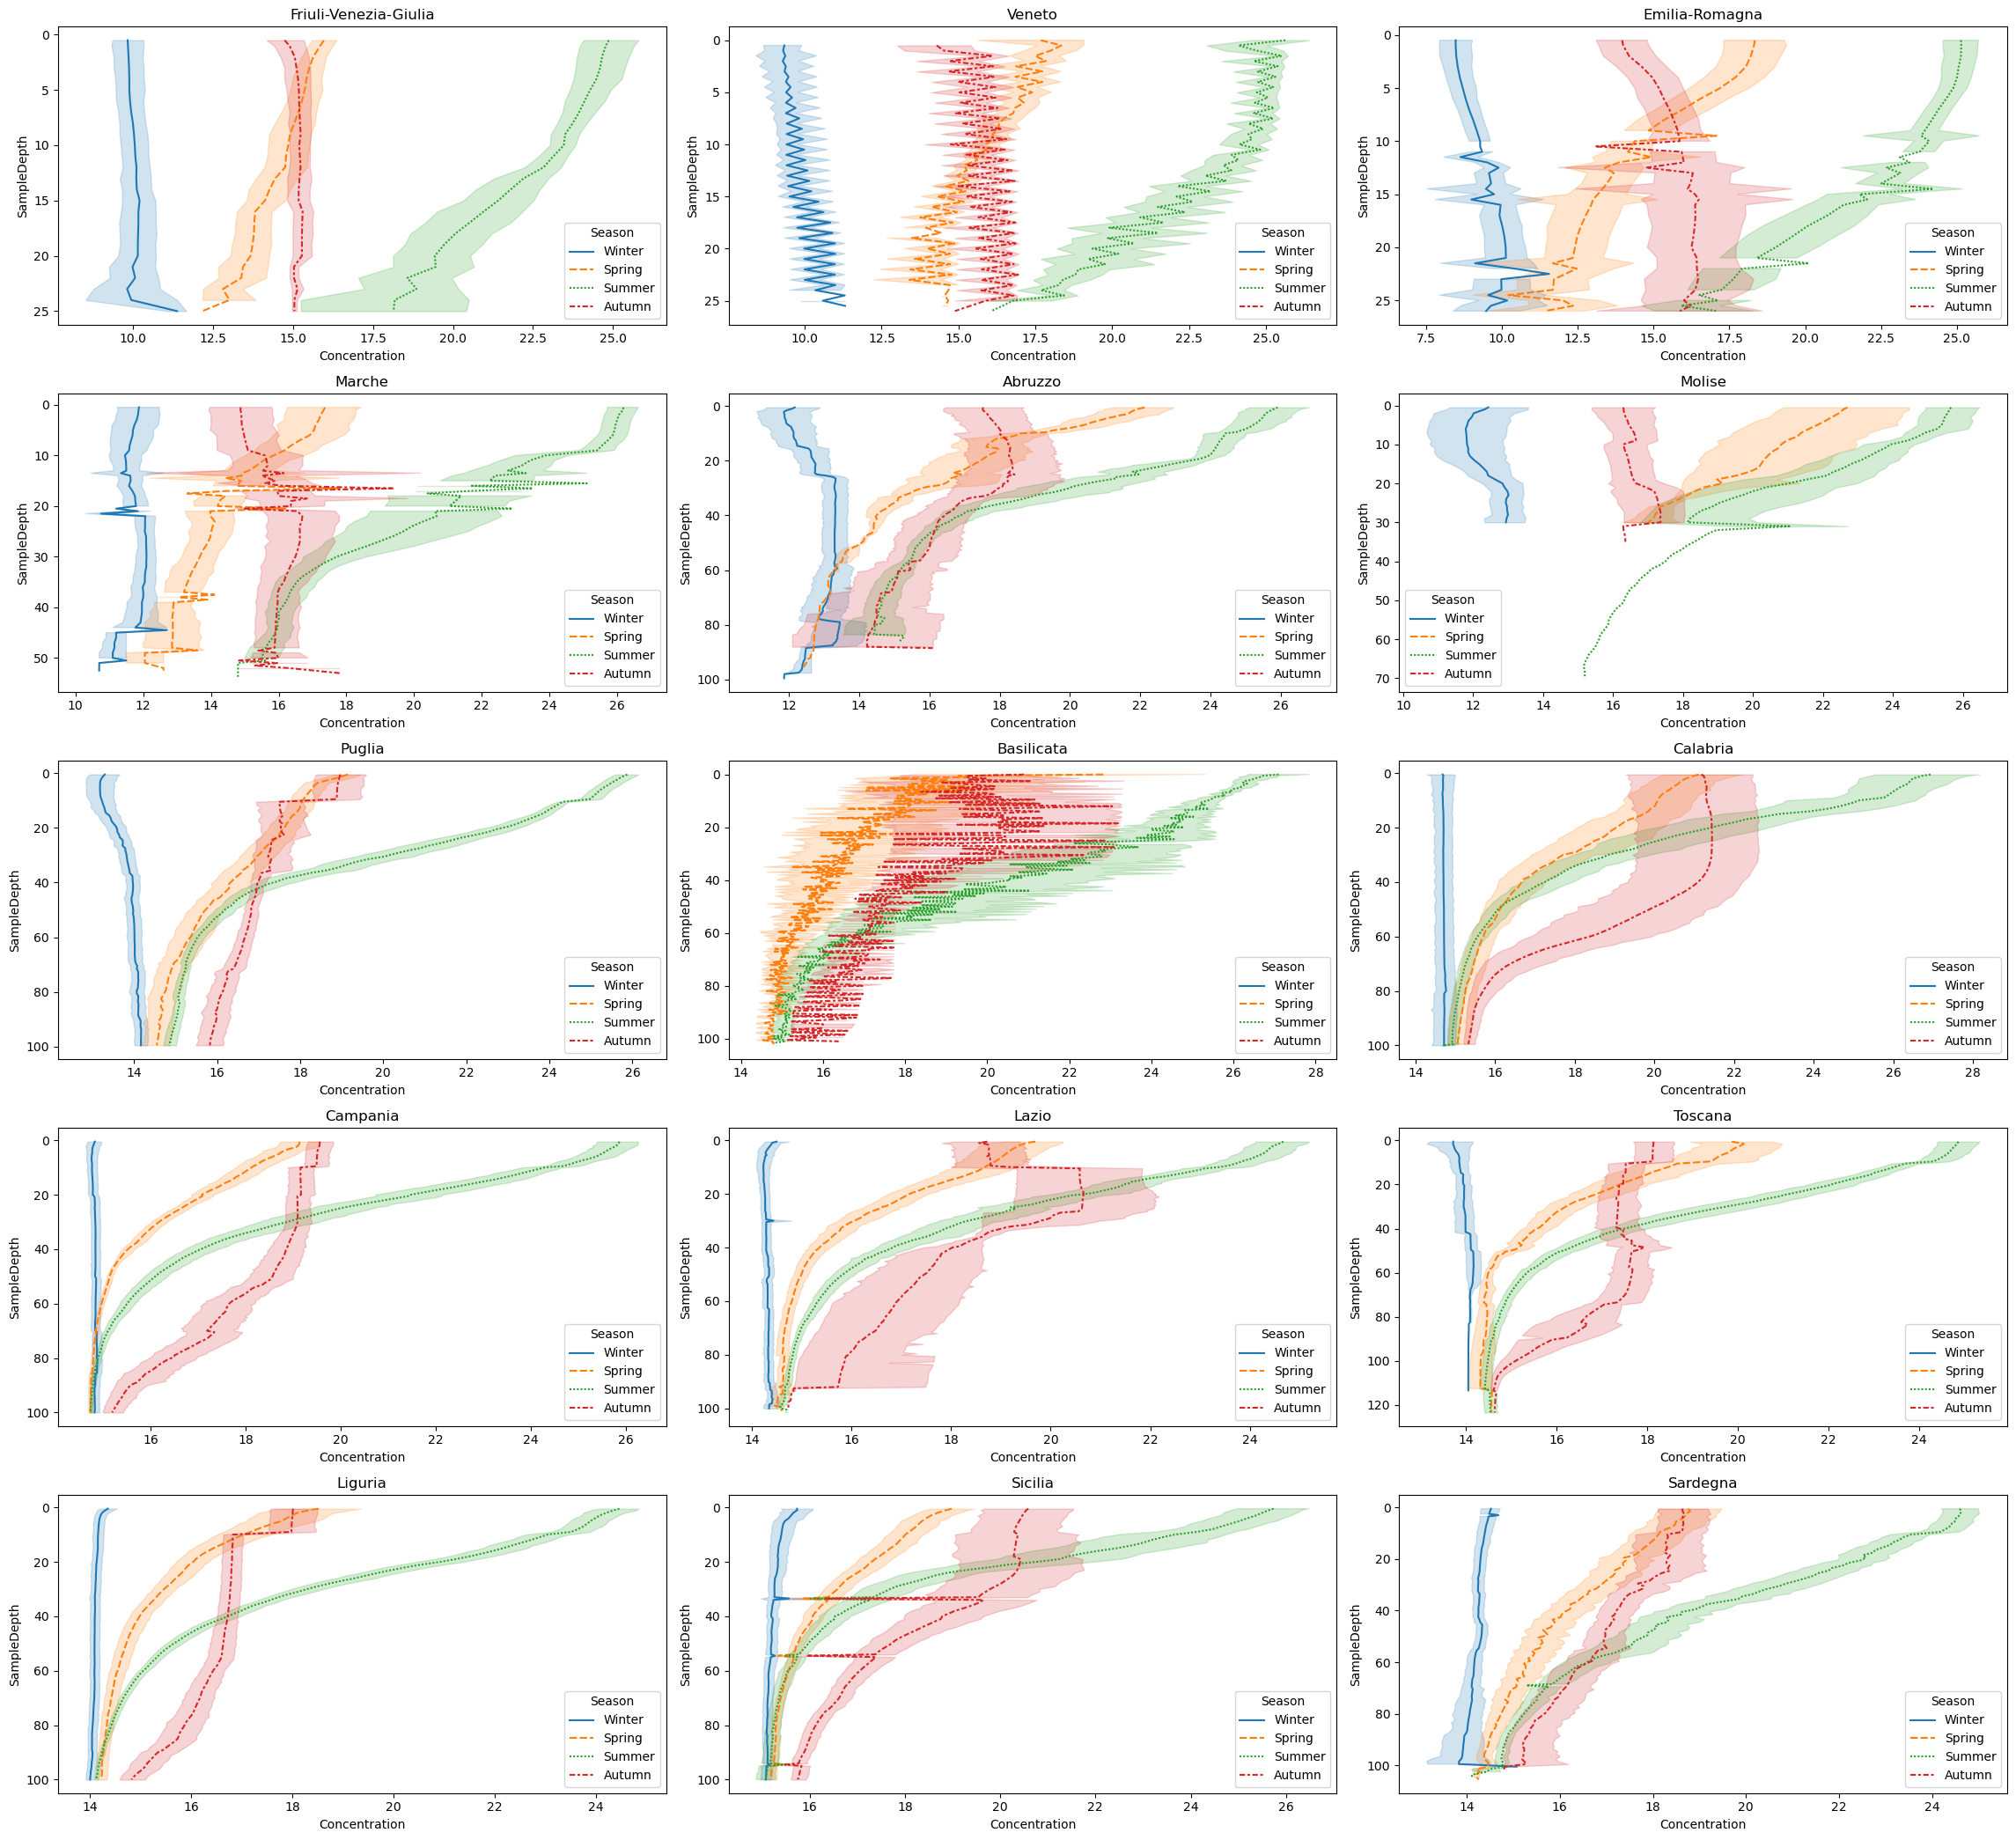

In [153]:
colors = sns.color_palette("tab10", n_colors=4)
color_dict = dict(zip(seasons, colors))

fig, axs = plt.subplots(5, 3, figsize=(23, 21))
axs = axs.ravel()
for ax, (Region, df_region) in zip(axs, Temp.groupby("Region", observed=True)): 
    sns.lineplot(
        data=df_region,
        x = "Concentration", 
        y = "SampleDepth", 
        orient = "y", 
        hue = "Season",
        style = "Season",
        #errorbar=None,
        palette=color_dict,
        ax = ax
    )
    ax.invert_yaxis()
    ax.set_title(Region)
plt.tight_layout()

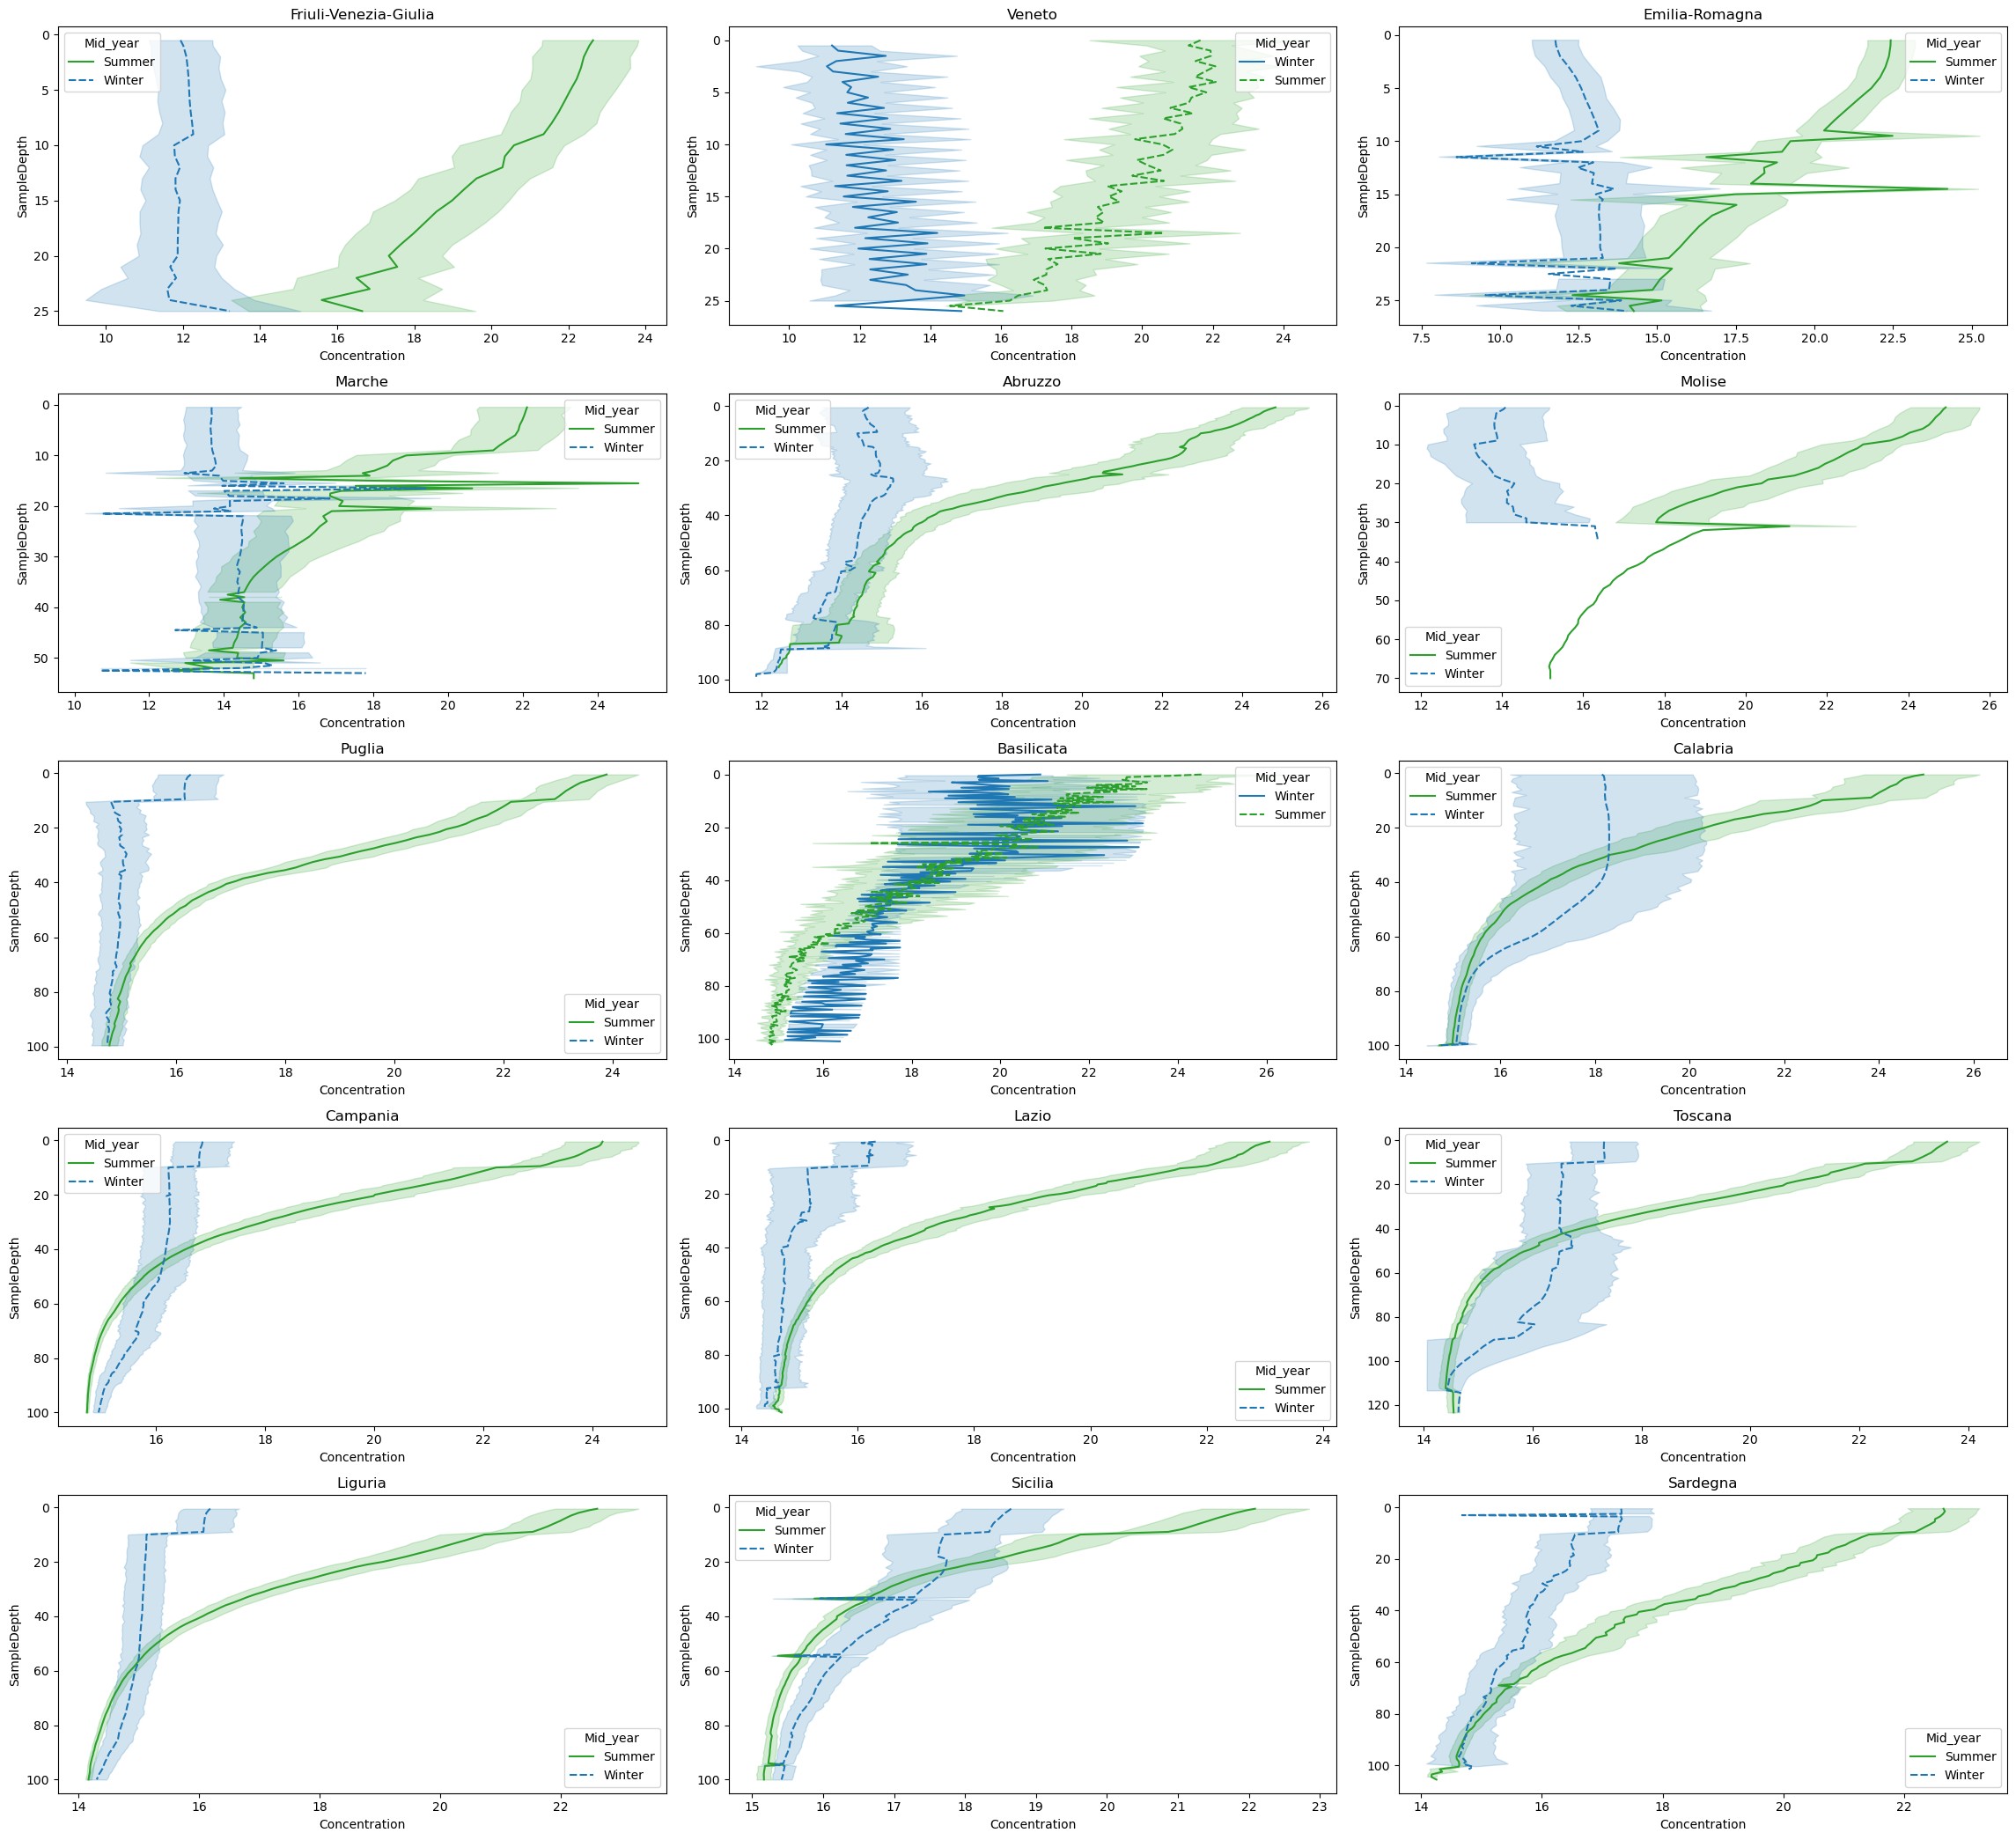

In [169]:
colors = sns.color_palette("tab10", n_colors=4)
color_dict = dict(zip(seasons, colors))

fig, axs = plt.subplots(5, 3, figsize=(23, 21))
axs = axs.ravel()
for ax, (Region, df_region) in zip(axs, Temp.groupby("Region", observed=True)): 
    sns.lineplot(
        data=df_region,
        x = "Concentration", 
        y = "SampleDepth", 
        orient = "y", 
        hue = "Mid_year",
        style = "Mid_year",
        #errorbar=None,
        palette=color_dict,
        ax = ax
    )
    ax.invert_yaxis()
    ax.set_title(Region)
plt.tight_layout()

# Salinity

In [44]:
Sal = df_chem_phys.query("Nutrient == 'Salinity' and Concentration >= 15")
Sal = Sal.groupby(["Region", "Date", "id", "SampleDepth"], observed=True).mean(numeric_only=True).reset_index()
Sal = modify_dataset.add_season_column(Sal, seasons)

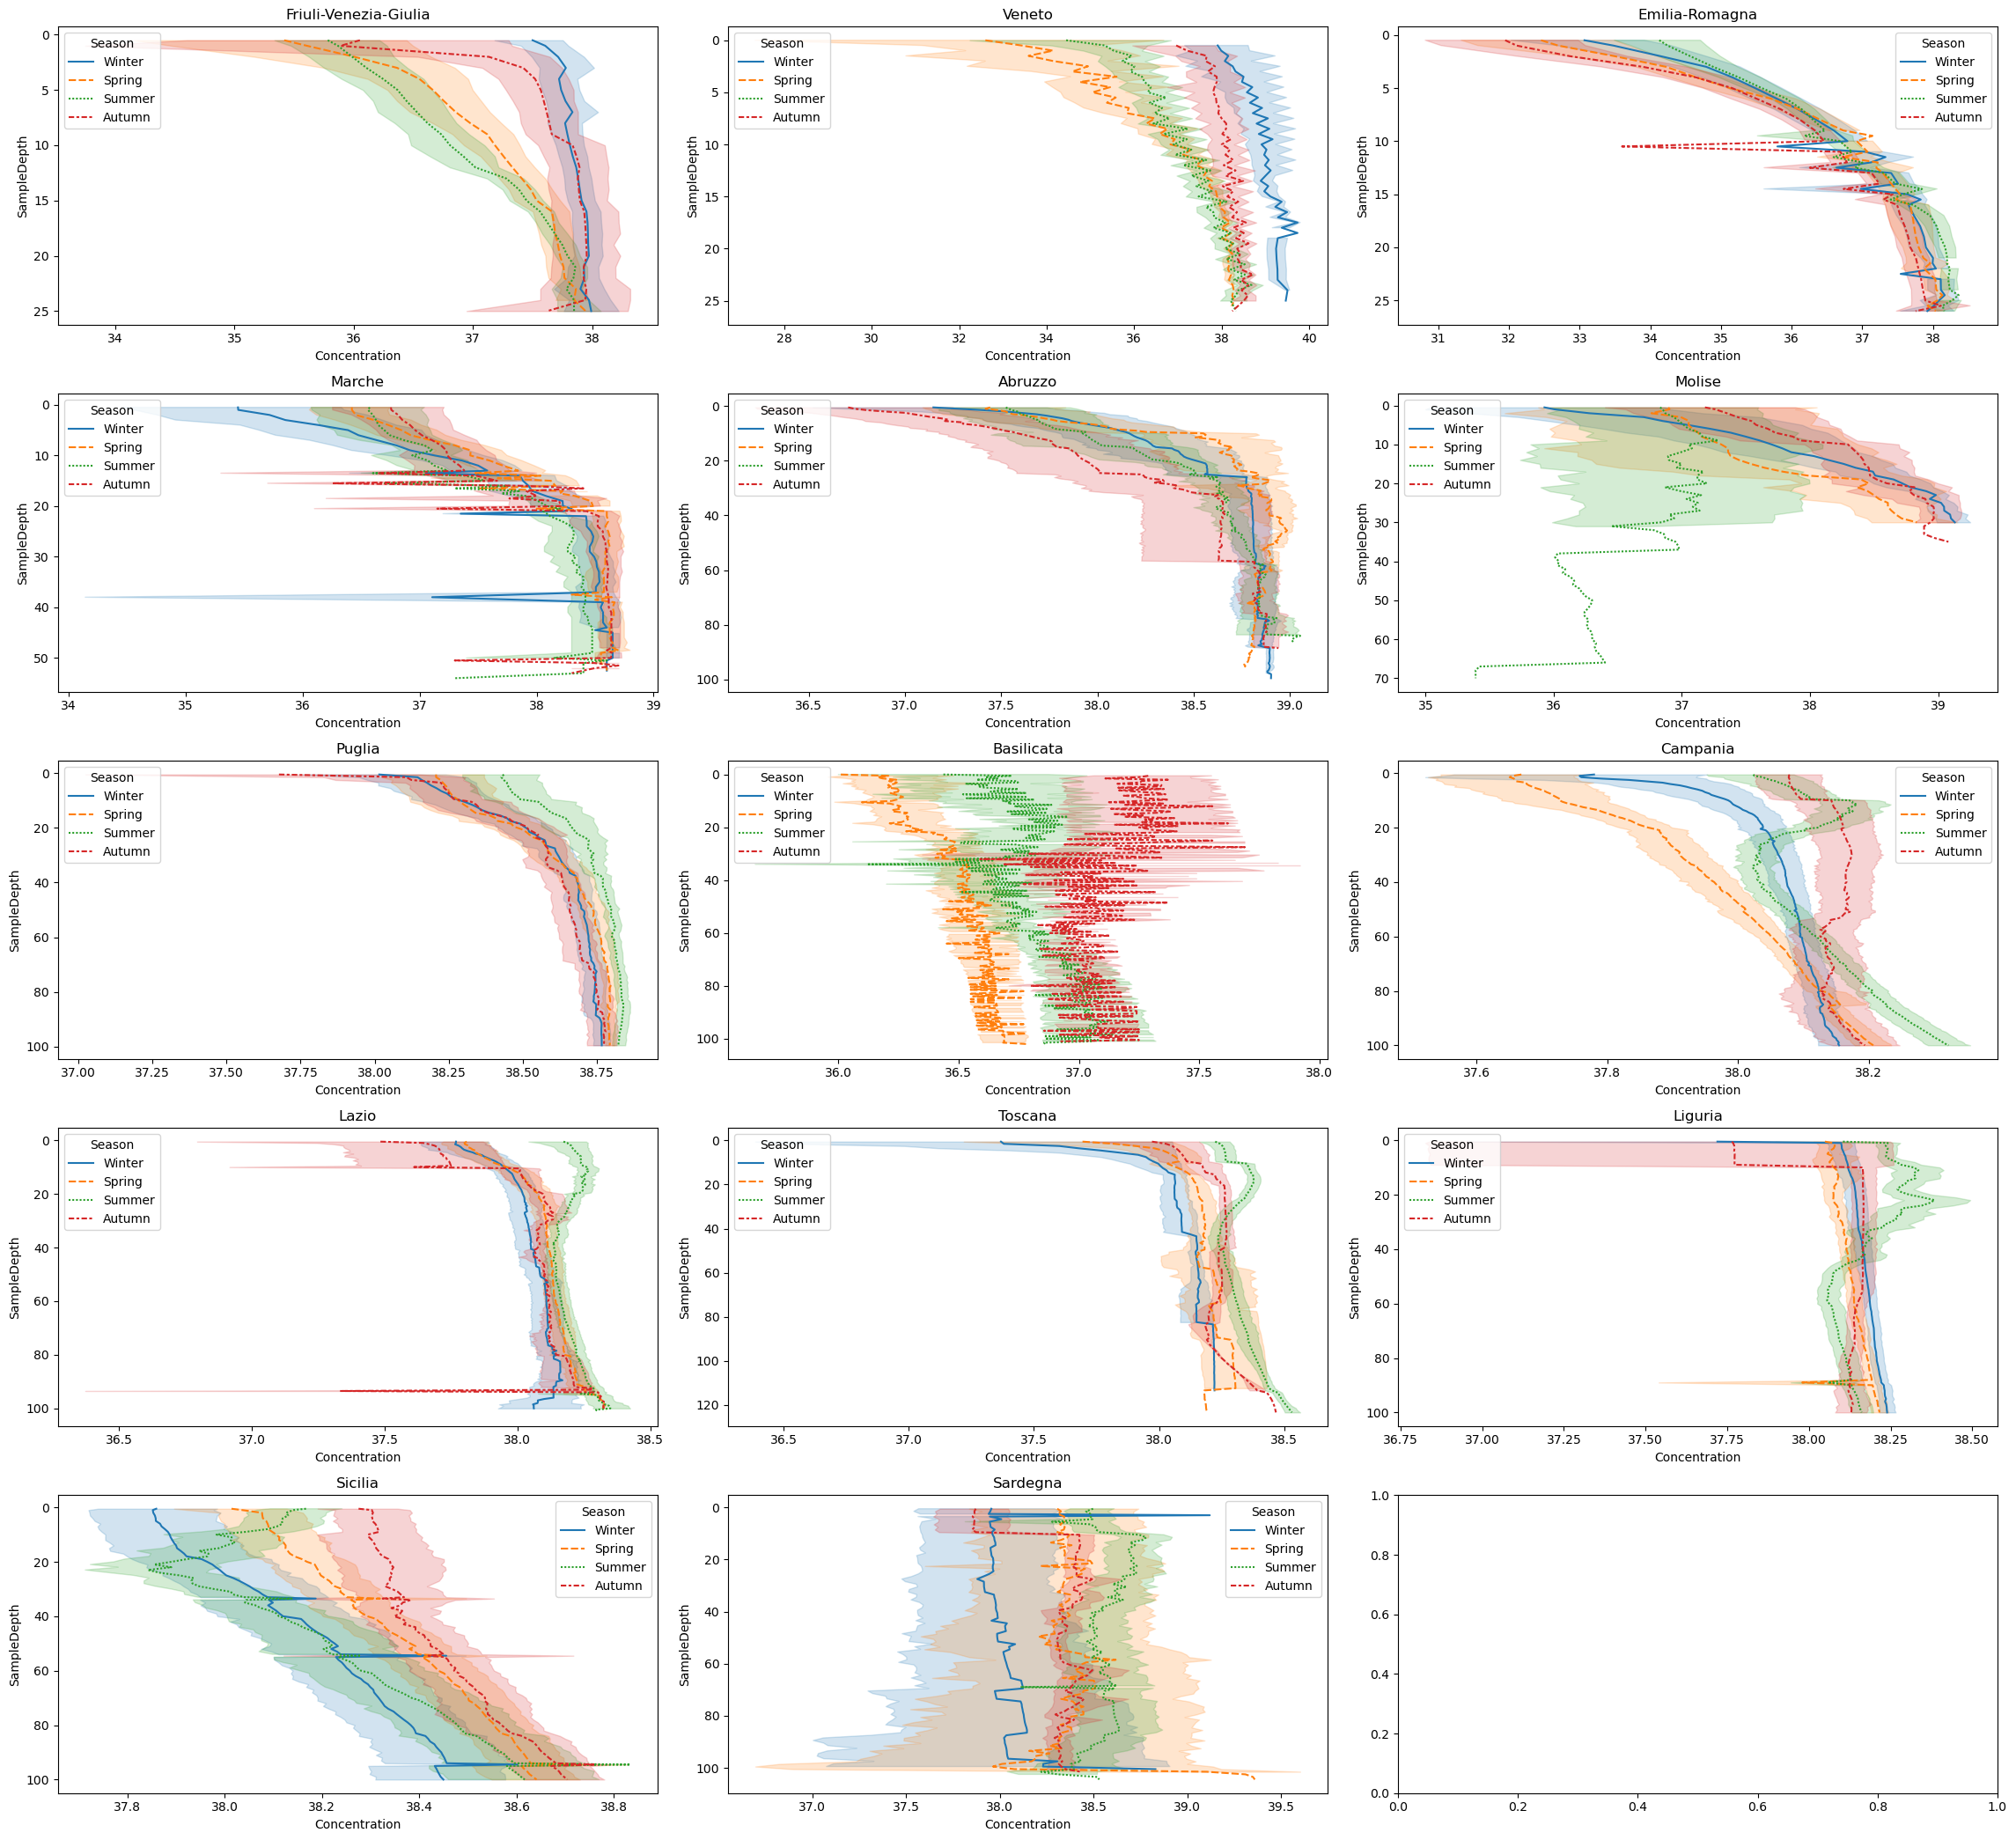

In [45]:
colors = sns.color_palette("tab10", n_colors=4)
color_dict = dict(zip(seasons, colors))

fig, axs = plt.subplots(5, 3, figsize=(23, 21))
axs = axs.ravel()
for ax, (Region, df_region) in zip(axs, Sal.groupby("Region", observed=True)): 
    sns.lineplot(
        data=df_region,
        x = "Concentration", 
        y = "SampleDepth", 
        orient = "y", 
        hue = "Season",
        style = "Season",
        #errorbar=None,
        palette=color_dict,
        ax = ax
    )
    ax.invert_yaxis()
    ax.set_title(Region)
plt.tight_layout()

# Chla

In [47]:
Chla = df_chem_phys.query("Nutrient == 'Chla' and Concentration > 0 and Concentration <= 20")
Chla = Chla.groupby(["Region", "Date", "id", "SampleDepth"], observed=True).mean(numeric_only=True).reset_index()
Chla = modify_dataset.add_season_column(Chla, seasons)

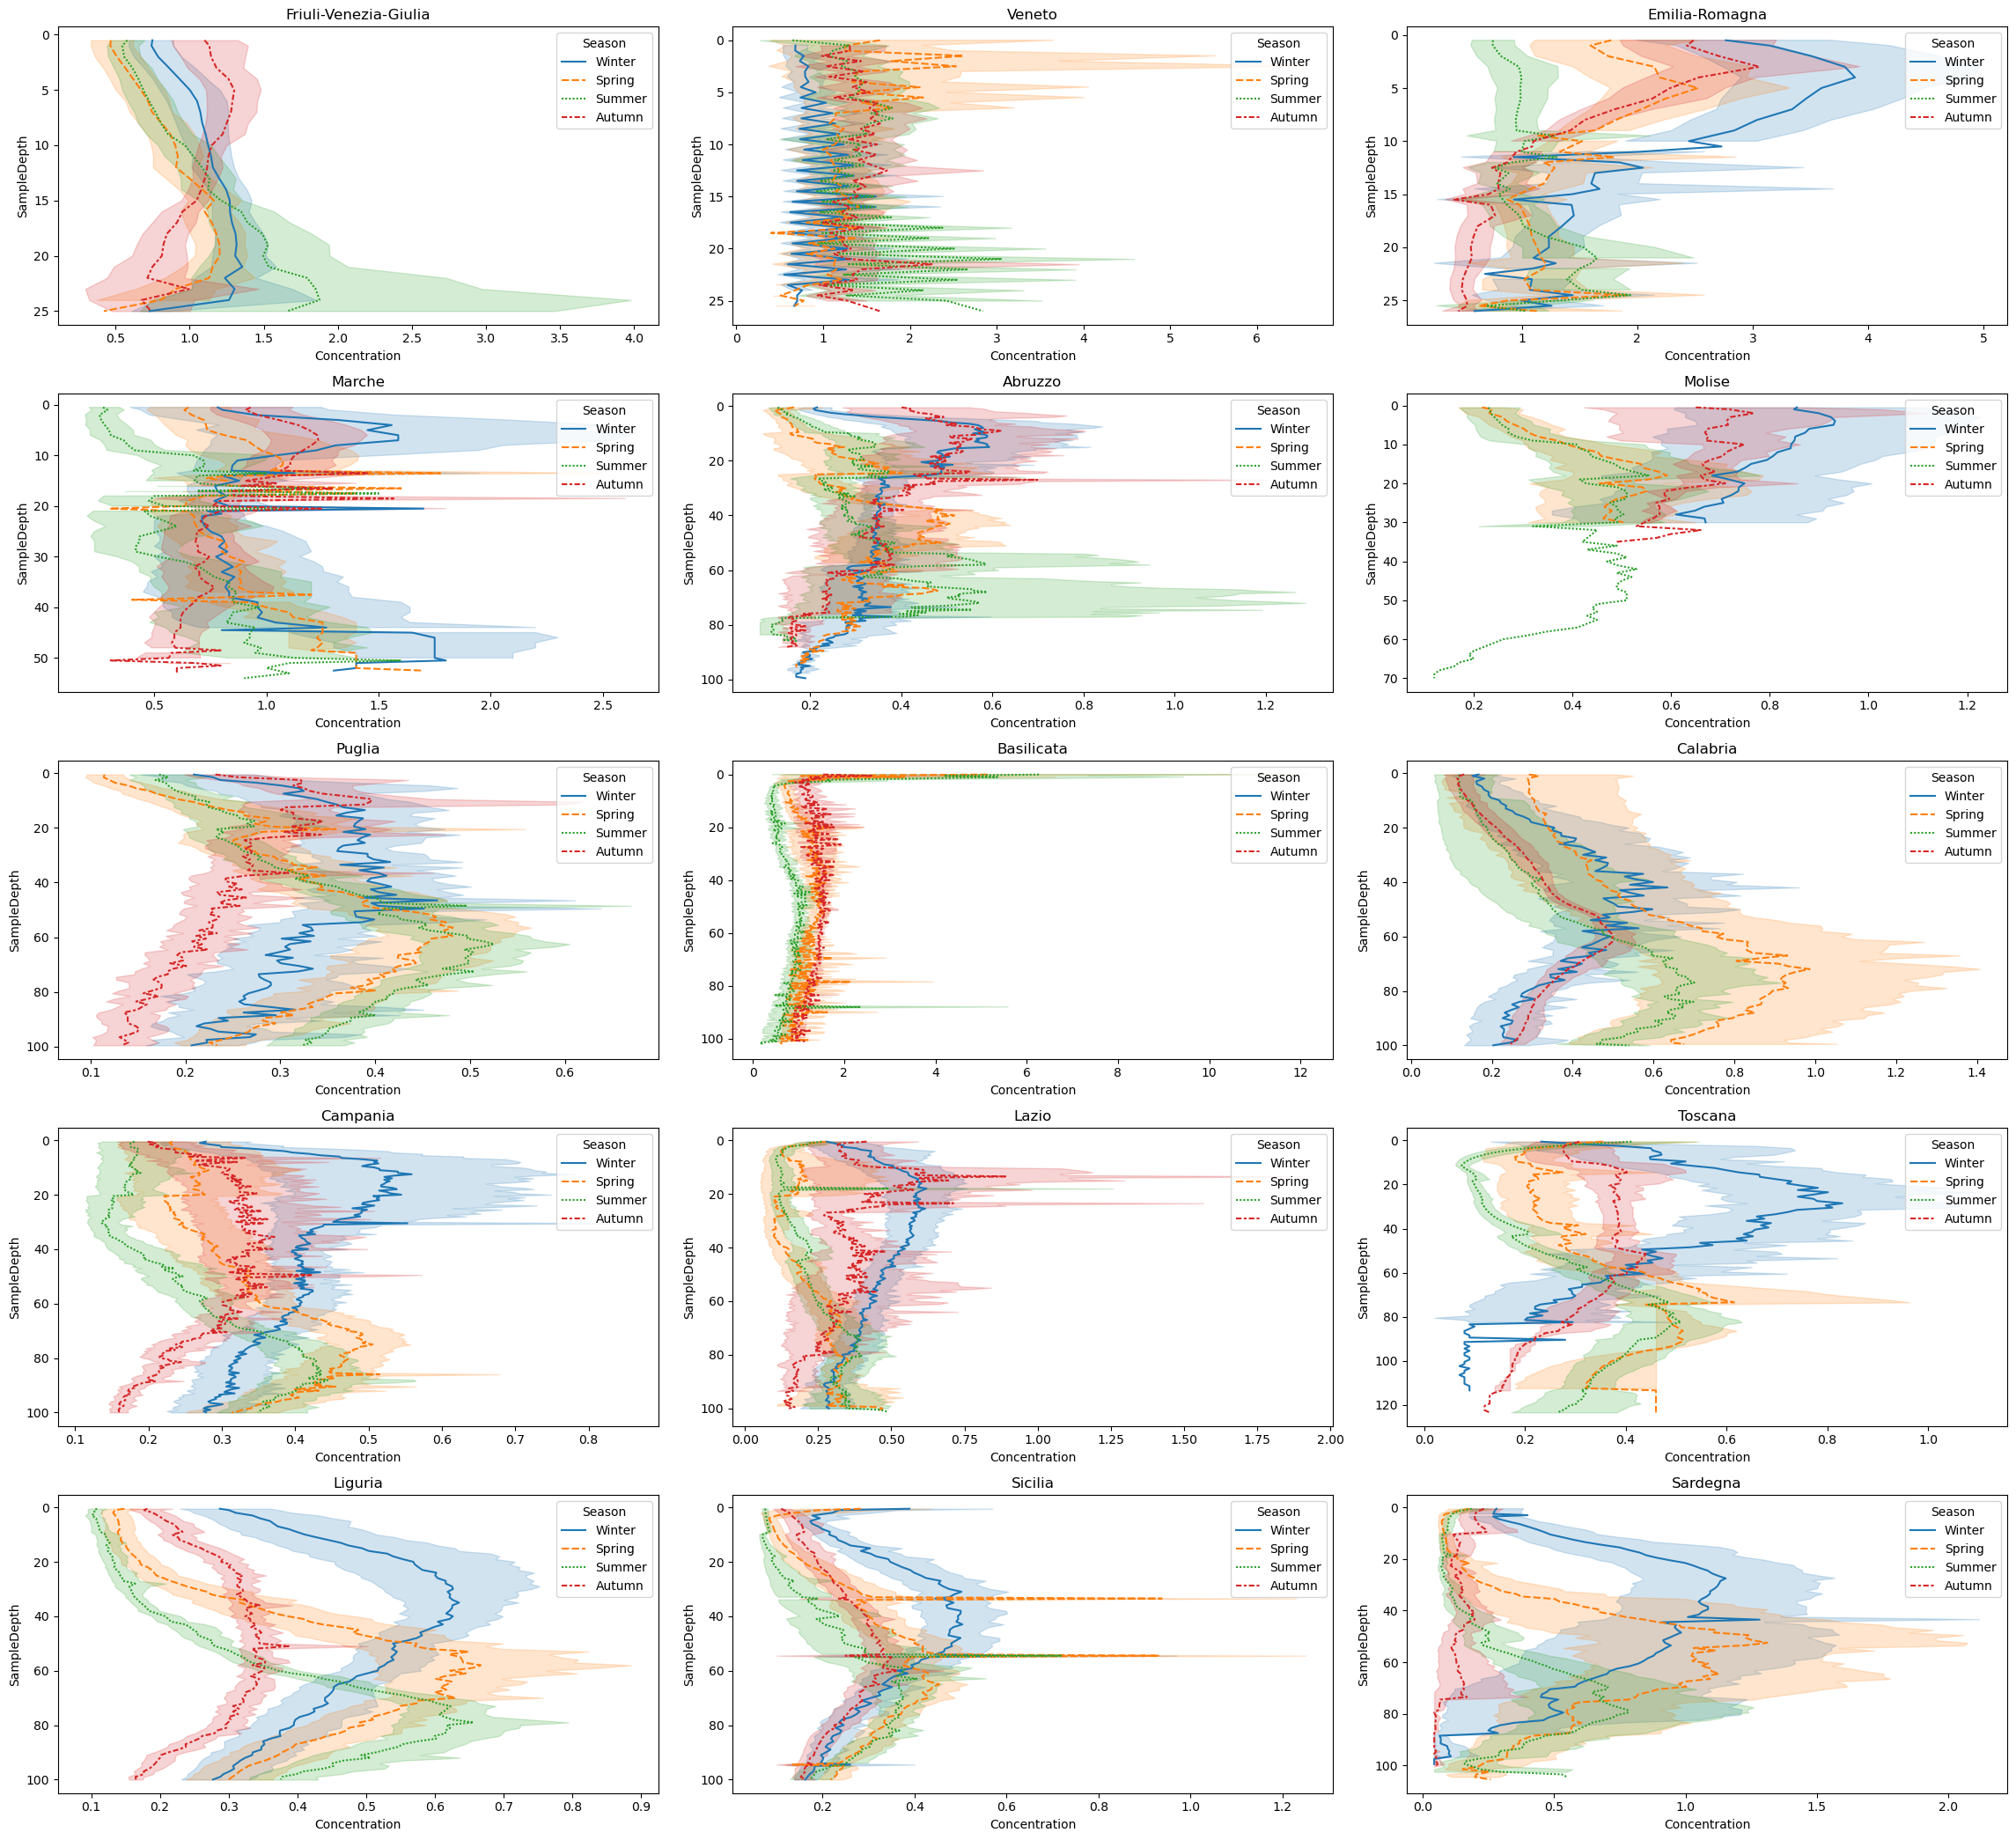

In [48]:
colors = sns.color_palette("tab10", n_colors=4)
color_dict = dict(zip(seasons, colors))

fig, axs = plt.subplots(5, 3, figsize=(23, 21))
axs = axs.ravel()
for ax, (Region, df_region) in zip(axs, Chla.groupby("Region", observed=True)): 
    sns.lineplot(
        data=df_region,
        x = "Concentration", 
        y = "SampleDepth", 
        orient = "y", 
        hue = "Season",
        style = "Season",
        #errorbar=None,
        palette=color_dict,
        ax = ax
    )
    ax.invert_yaxis()
    ax.set_title(Region)
plt.tight_layout()